In [1]:
# Step 1: Install required packages
!pip install spectral scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [2]:
# Step 2: Import libraries
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from spectral import open_image
import scipy.io as sio
import matplotlib.pyplot as plt

In [3]:
# Step 3: Load Indian Pines data (download from URL if not available)
import os
import requests

def download_data():
    if not os.path.exists("Indian_pines_corrected.mat"):
        url = "http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines_corrected.mat"
        r = requests.get(url)
        open("Indian_pines_corrected.mat", "wb").write(r.content)

    if not os.path.exists("Indian_pines_gt.mat"):
        url = "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
        r = requests.get(url)
        open("Indian_pines_gt.mat", "wb").write(r.content)

download_data()

In [4]:
# Step 4: Load dataset
data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

print("Data shape:", data.shape)
print("Label shape:", labels.shape)

Data shape: (145, 145, 200)
Label shape: (145, 145)


In [5]:
#Normalize the spectral bands (Min-Max Scaling)
def normalize_data(data):
    reshaped = data.reshape(-1, data.shape[2])
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(reshaped)
    return normalized.reshape(data.shape)

normalized_data = normalize_data(data)

In [6]:
#Pad the data for patch extraction
def pad_with_zeros(data, margin):
    return np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

In [7]:
# Extract spectral-spatial patches
def extract_patches(data, labels, patch_size=11):
    margin = patch_size // 2
    padded_data = pad_with_zeros(data, margin)

    patch_data = []
    patch_labels = []
    h, w = labels.shape

    for r in range(h):
        for c in range(w):
            label = labels[r, c]
            if label == 0:
                continue  # skip unlabeled pixels
            patch = padded_data[r:r+patch_size, c:c+patch_size]
            patch_data.append(patch)
            patch_labels.append(label - 1)  # labels start from 0

    return np.array(patch_data), np.array(patch_labels)

patch_size = 11
X, y = extract_patches(normalized_data, labels, patch_size=patch_size)

print(f"Patch shape: {X.shape}, Labels shape: {y.shape}")


Patch shape: (10249, 11, 11, 200), Labels shape: (10249,)


In [8]:
from tensorflow.keras import layers, models
import tensorflow as tf

def spectral_branch(input_tensor, patch_size, bands):
    x = layers.Reshape((patch_size * patch_size, bands))(input_tensor)  # (121, bands)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    return x

def spatial_branch(input_tensor, patch_size, bands):
    x = layers.Reshape((patch_size, patch_size, bands))(input_tensor)
    x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return x

def global_context_learning(fused_feat, reduction=16):
    # Compute attention weights (context modeling)
    context = layers.Dense(fused_feat.shape[-1] // reduction, activation='relu')(fused_feat)
    context = layers.Dense(fused_feat.shape[-1], activation='softmax')(context)

    # Reweight the fused features with attention
    context_feat = layers.Multiply()([fused_feat, context])

    # Combine context with original fused features
    enhanced_feat = layers.Add()([fused_feat, context_feat])

    return enhanced_feat


def create_model(patch_size=11, bands=200, num_classes=16):
    input_layer = layers.Input(shape=(patch_size, patch_size, bands))

    # Spectral and Spatial branches
    spec_feat = spectral_branch(input_layer, patch_size, bands)
    spat_feat = spatial_branch(input_layer, patch_size, bands)

    # Adaptive fusion
    concat = layers.Concatenate()([spec_feat, spat_feat])
    attention = layers.Dense(2, activation='softmax')(concat)
    spec_weight, spat_weight = layers.Lambda(lambda x: tf.split(x, 2, axis=-1))(attention)

    spec_weighted = layers.Multiply()([spec_weight, spec_feat])
    spat_weighted = layers.Multiply()([spat_weight, spat_feat])
    fused_feat = layers.Add()([spec_weighted, spat_weighted])

    # Add Global Context Learning here
    enhanced_feat = global_context_learning(fused_feat)

    # Classifier
    x = layers.Dense(128, activation='relu')(enhanced_feat)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=input_layer, outputs=output_layer)


# Instantiate the model
bands = X.shape[-1]
num_classes = np.max(y) + 1
model = create_model(patch_size=patch_size, bands=bands, num_classes=num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 121, 200)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 11, 11,    │          0 │ input_layer[0][0] │
│                     │ 200)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 121, 32)   │     19,232 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 11, 11,    │     57,632 │ reshape_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 121, 64)   │      6,208 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 11, 11,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        258 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 1),       │          0 │ dense[0][0]       │
│                     │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ lambda[0][0],     │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 64)        │          0 │ lambda[0][1],     │
│ (Multiply)          │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        320 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 64)        │          0 │ add[0][0],        │
│ (Multiply)          │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ add[0][0],      

 Total params: 112,790 (440.59 KB)

 Trainable params: 112,790 (440.59 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split the patch data and labels
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# One-hot encode labels
y_train = to_categorical(y_train_raw, num_classes=num_classes)
y_test = to_categorical(y_test_raw, num_classes=num_classes)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_raw),
                                     y=y_train_raw)

class_weights_dict = dict(enumerate(class_weights))

In [12]:
margin = patch_size // 2
height, width = labels.shape

# Pad the normalized input data
padded_data = np.pad(normalized_data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

pred_map = np.zeros((height, width))

for r in range(height):
    for c in range(width):
        if labels[r, c] == 0:
            continue
        patch = padded_data[r:r+patch_size, c:c+patch_size]
        patch_input = patch[np.newaxis, ...]  # shape: (1, 11, 11, bands)
        prediction = model.predict(patch_input, verbose=0)
        pred_class = np.argmax(prediction)
        pred_map[r, c] = pred_class + 1  # add 1 to match label map style

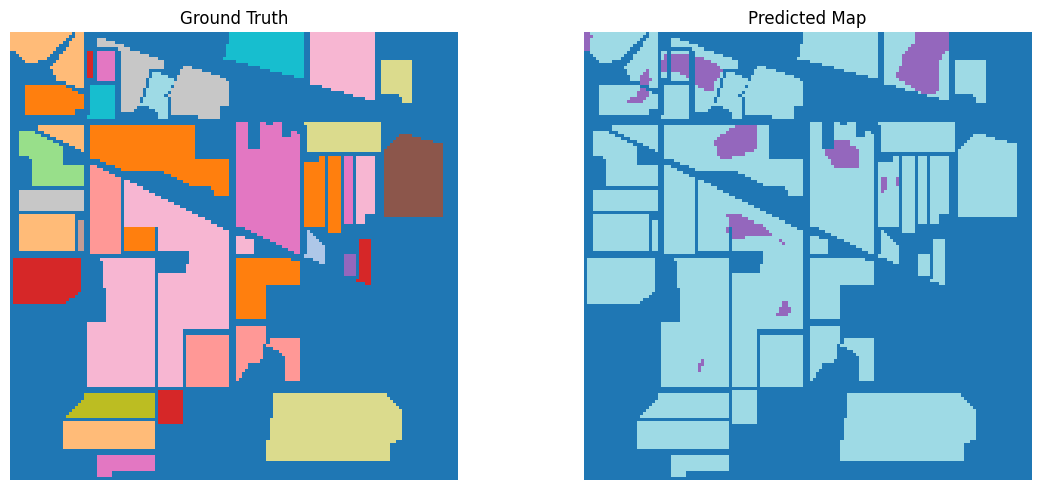

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def show_maps(gt, pred, title="Classification"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(gt, cmap='tab20')
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    axs[1].imshow(pred, cmap='tab20')
    axs[1].set_title(title)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

show_maps(labels, pred_map, title="Predicted Map")

In [16]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    f1_score,
    precision_score,
    recall_score
)

# Compute metrics
oa = accuracy_score(y_true_raw, y_pred_raw)  # Overall Accuracy
kappa = cohen_kappa_score(y_true_raw, y_pred_raw)  # Kappa coefficient
f1_macro = f1_score(y_true_raw, y_pred_raw, average='macro')  # Macro F1
precision_macro = precision_score(y_true_raw, y_pred_raw, average='macro')
recall_macro = recall_score(y_true_raw, y_pred_raw, average='macro')


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
print("\n📋 Classification Report:")
print(classification_report(y_true_raw, y_pred_raw, digits=4))



📋 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        14
           1     0.0000    0.0000    0.0000       428
           2     0.0000    0.0000    0.0000       249
           3     0.0000    0.0000    0.0000        71
           4     0.0000    0.0000    0.0000       145
           5     0.0000    0.0000    0.0000       219
           6     0.0000    0.0000    0.0000         8
           7     0.0000    0.0000    0.0000       143
           8     0.0000    0.0000    0.0000         6
           9     0.0000    0.0000    0.0000       292
          10     0.0000    0.0000    0.0000       737
          11     0.0000    0.0000    0.0000       178
          12     0.0000    0.0000    0.0000        61
          13     0.0000    0.0000    0.0000       380
          14     0.0000    0.0000    0.0000       116
          15     0.0097    1.0000    0.0193        28

    accuracy                         0.0091      3075


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
print("Model Evaluation Summary:")
print(f" Overall Accuracy     : {oa:.4f}")
print(f" Cohen's Kappa       : {kappa:.4f}")
print(f" Macro F1 Score       : {f1_macro:.4f}")
print(f" Macro Precision      : {precision_macro:.4f}")
print(f" Macro Recall         : {recall_macro:.4f}")


Model Evaluation Summary:
 Overall Accuracy     : 0.0091
 Cohen's Kappa       : 0.0004
 Macro F1 Score       : 0.0012
 Macro Precision      : 0.0006
 Macro Recall         : 0.0625


In [14]:
# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred_raw = np.argmax(y_pred_probs, axis=1)
y_true_raw = np.argmax(y_test, axis=1)

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


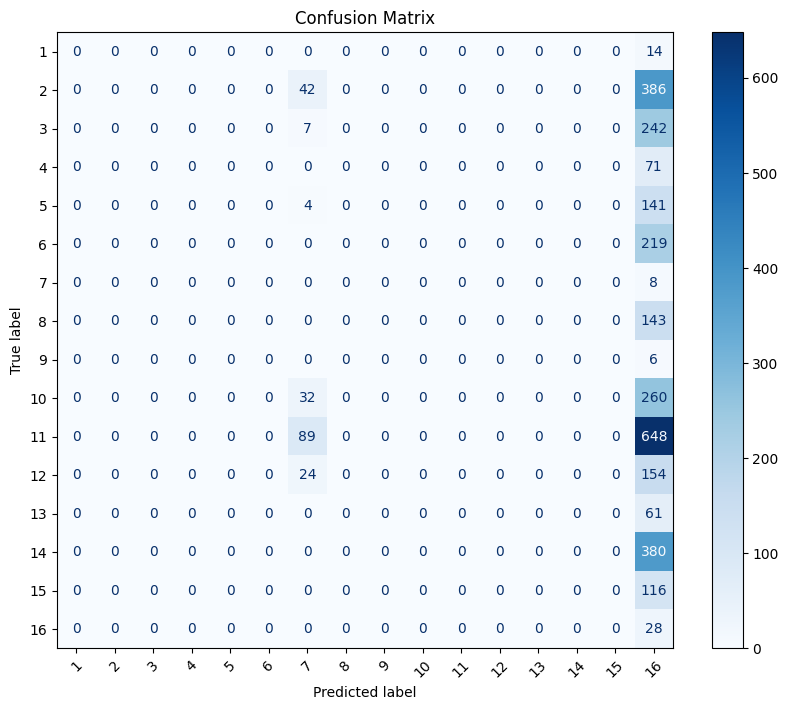

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true_raw, y_pred_raw)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, num_classes+1))
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()